In [14]:
#!/usr/bin/env python3
import scipy.io.wavfile
from python_speech_features import mfcc, delta
import numpy as np
import math

import tensorflow as tf
from tensorflow.keras import layers
from keras.utils import to_categorical
import keras.utils
import IPython.display
import matplotlib.pyplot as plt

import os
os.environ["PATH"] += os.pathsep + '/Users/dgrogan/anaconda3/pkgs/graphviz-2.40.1-hefbbd9a_2/bin'

In [18]:
np.random.seed(1234)

# Audio pre-processing cell


files = [ 'cousinhenry_01_trollope_8khz.wav',
'siegeofcorinth_2_byron_8khz.wav',
'upperroom_16_ryle_8khz.wav',
'vorst_14_machiavelli_8khz.wav',
]

# This constant is the number of entries of the all_examples list below that
# correspond to one training example.
# * The 13 is magic -- it's the default number of mfcc... frequencies(?) calculated
#   by many places on the web and in the python library we used.
# * The 49 comes from a combination of our sample size and mfcc window. Our sample
#   size is half second and we calculate mfccs in a 25ms window with a 10ms stride.
#   (0.5 - 0.01) / 0.01 = 49
# * Multiply that * 2 because we are also calculating the first derivative of the
#   mfcc... cepstrum(?), which seems to be common (further adding 2nd derivative
#   is also common).
# * The + 1 is because the label for each sample comes right after the above.
height_of_one_training_example = 49 * 13 * 2 + 1

label = 0
all_examples = []
for one_file in files:
  label += 1
  rate, data = scipy.io.wavfile.read(one_file)
  total_length_of_wave = data.shape[0]
  print ("just read file number %d which contains %d audio samples and is named %s Now analying it:" %
         (label, total_length_of_wave, one_file))
  assert rate == 8000, "rate was %d" % rate

  half_second_length = 4000
  start_index_of_half_second = 0
  num_training_example_in_this_file = 0
  while total_length_of_wave - start_index_of_half_second >= half_second_length:
    num_training_example_in_this_file += 1
    
    # The class with the least data has 752, so let's do 750 samples each for class balance.
    if num_training_example_in_this_file == 751:
      break;
    
    if num_training_example_in_this_file % 500 == 0:
      print ("\t analyzing training sample number %d" % num_training_example_in_this_file)

    this_training_example_raw = data[start_index_of_half_second:start_index_of_half_second + half_second_length]
    start_index_of_half_second += half_second_length
    assert len(this_training_example_raw) == 4000, len(this_training_example_raw)
    mfccs = mfcc(this_training_example_raw, 8000)
    assert mfccs.shape == (49, 13), mfccs.shape

    # Alfredo used 2 here, and changing it doesn't change the output size, so *shrug*.
    first_derivative = delta(mfccs, 2)
    assert first_derivative.shape == (49, 13), first_derivative.shape
    all_examples.extend(mfccs.flatten().tolist())
    all_examples.extend(first_derivative.flatten().tolist())
    all_examples.append(label)
    assert len(all_examples) % height_of_one_training_example == 0, (
        "num_training_example_in_this_file = %d" % num_training_example_in_this_file)

just read file number 1 which contains 7305509 audio samples and is named cousinhenry_01_trollope_8khz.wav Now analying it:
	 analyzing training sample number 500
just read file number 2 which contains 12400013 audio samples and is named siegeofcorinth_2_byron_8khz.wav Now analying it:
	 analyzing training sample number 500
just read file number 3 which contains 36554719 audio samples and is named upperroom_16_ryle_8khz.wav Now analying it:
	 analyzing training sample number 500
just read file number 4 which contains 3008270 audio samples and is named vorst_14_machiavelli_8khz.wav Now analying it:
	 analyzing training sample number 500


In [19]:
np.random.seed(123456)

# This cell massages the audio features into a format Keras likes and splits into test/dev sets.

# TODO(dgrogan): Parts of the first half and last half of this cell are inverses and can be combined.
all_examples_np = np.array(all_examples)
all_examples_np = all_examples_np.reshape((height_of_one_training_example, -1), order='F')

#print ("all_examples_np.shape = %s, so we have %d training samples" % (
#       all_examples_np.shape, all_examples_np.shape[1]))
assert all_examples_np[-1, 0] == 1, (
    "make sure the last row labels the first column as belonging to file number 1 %s" % all_examples_np[-1, 0])

shuffled_examples = all_examples_np.T
np.random.shuffle(shuffled_examples)
shuffled_examples = shuffled_examples.T

# I changed to 0.9 when I thought we might not have enough data. We can change it back to whatever.
training_pct = 0.9

number_of_training_examples = int(math.ceil(all_examples_np.shape[1] * training_pct))

# The labels are the last entry in each of the columns, hence the -1 below.
X_train = shuffled_examples[0:-1, 0:number_of_training_examples]
Y_train = shuffled_examples[-1:, 0:number_of_training_examples]
X_dev   = shuffled_examples[0:-1, number_of_training_examples:]
Y_dev   = shuffled_examples[-1:, number_of_training_examples:]

# The labels in Y are an integer corresponding to the speaker number.
# In Keras, you want (number of data, attributes). So we reshape.
# Want: (see coursera M4 - Keras Tutorial)
# if training_pct = 0.8, (11853, 1274) (11853, 1) (2963, 1274) (2963, 1)
X_train = X_train.T
Y_train = Y_train.T
X_dev = X_dev.T
Y_dev = Y_dev.T

# Sanity check the train/dev shapes.
print(X_train.shape, Y_train.shape, X_dev.shape, Y_dev.shape)

# Sanity check the one-hot encoding.
print(Y_train[0:5])
print(Y_dev[0:5])
Y_train = to_categorical(Y_train - 1) # -1 because to_categorical seems to expect labels to start at 0
Y_dev = to_categorical(Y_dev - 1)
print(Y_train[0:5])
print(Y_dev[0:5])

(2700, 1274) (2700, 1) (300, 1274) (300, 1)
[[3.]
 [3.]
 [4.]
 [2.]
 [2.]]
[[3.]
 [4.]
 [2.]
 [4.]
 [4.]]
[[0. 0. 1. 0.]
 [0. 0. 1. 0.]
 [0. 0. 0. 1.]
 [0. 1. 0. 0.]
 [0. 1. 0. 0.]]
[[0. 0. 1. 0.]
 [0. 0. 0. 1.]
 [0. 1. 0. 0.]
 [0. 0. 0. 1.]
 [0. 0. 0. 1.]]


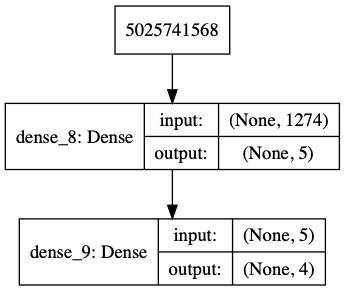

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_8 (Dense)              (None, 5)                 6375      
_________________________________________________________________
dense_9 (Dense)              (None, 4)                 24        
Total params: 6,399
Trainable params: 6,399
Non-trainable params: 0
_________________________________________________________________
None


In [20]:
#Keras
model = tf.keras.Sequential()

#hidden layers
model.add(layers.Dense(5, activation='relu', input_dim=X_train.shape[1]))
model.add(layers.Dense(len(files), activation='softmax'))

model.compile(optimizer=tf.train.AdamOptimizer(0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

keras.utils.plot_model(model, to_file='test_keras_plot_model.png', show_shapes=True)
display(IPython.display.Image('test_keras_plot_model.png'))
print(model.summary())
# I don't know where 140240419526080 in the picture came from

In [21]:
%%time
history_object = model.fit(X_train, Y_train, epochs=30, batch_size=128, verbose=2, shuffle=True,
         validation_data=(X_dev, Y_dev))


Train on 2700 samples, validate on 300 samples
Epoch 1/30
 - 0s - loss: 2.3026 - acc: 0.4000 - val_loss: 1.1778 - val_acc: 0.4833
Epoch 2/30
 - 0s - loss: 1.0902 - acc: 0.5022 - val_loss: 0.9671 - val_acc: 0.6533
Epoch 3/30
 - 0s - loss: 0.8925 - acc: 0.6756 - val_loss: 0.8294 - val_acc: 0.7267
Epoch 4/30
 - 0s - loss: 0.7879 - acc: 0.7156 - val_loss: 0.8122 - val_acc: 0.7200
Epoch 5/30
 - 0s - loss: 0.7268 - acc: 0.7304 - val_loss: 0.7907 - val_acc: 0.7433
Epoch 6/30
 - 0s - loss: 0.6809 - acc: 0.7489 - val_loss: 0.7373 - val_acc: 0.7600
Epoch 7/30
 - 0s - loss: 0.6500 - acc: 0.7807 - val_loss: 0.7074 - val_acc: 0.7833
Epoch 8/30
 - 0s - loss: 0.6098 - acc: 0.8430 - val_loss: 0.6981 - val_acc: 0.7967
Epoch 9/30
 - 0s - loss: 0.5760 - acc: 0.8641 - val_loss: 0.6620 - val_acc: 0.8433
Epoch 10/30
 - 0s - loss: 0.5301 - acc: 0.8922 - val_loss: 0.6314 - val_acc: 0.8700
Epoch 11/30
 - 0s - loss: 0.5132 - acc: 0.8981 - val_loss: 0.6443 - val_acc: 0.8733
Epoch 12/30
 - 0s - loss: 0.4711 - acc

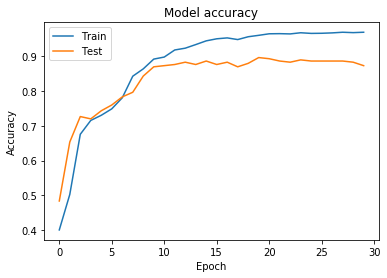

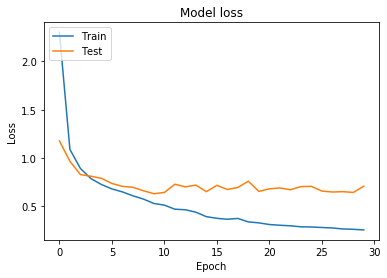

In [22]:
# Plot training & validation accuracy values
plt.plot(history_object.history['acc'])
plt.plot(history_object.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history_object.history['loss'])
plt.plot(history_object.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()